In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity.keras import UpdatePruningStep

/Users/hhussain0901/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [3]:
def create_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
def build_generator():
    noise = layers.Input(shape=(100,))
    x = layers.Dense(256 * 7 * 7, activation='relu')(noise)
    x = layers.Reshape((7, 7, 256))(x)
    
    # First transposed convolution layer
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    # Second transposed convolution layer
    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    # Output layer
    x = layers.Conv2DTranspose(1, kernel_size=3, strides=1, padding='same', activation='sigmoid')(x)
    
    return tf.keras.models.Model(noise, x)


In [10]:
def build_discriminator():
    image_input = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(image_input)
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    
    # Validity output
    validity = layers.Dense(1, activation="sigmoid")(x)
    
    discriminator = tf.keras.models.Model(image_input, validity)
    discriminator.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))
    
    return discriminator


In [14]:
def train_dcgan(generator, discriminator, epochs=10000, batch_size=64):
    # Freeze the discriminator during the generator training
    discriminator.trainable = False
    
    # Combined model: generator and discriminator
    combined = tf.keras.models.Model(generator.input, discriminator(generator.output))
    combined.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))
    
    for epoch in range(epochs):
        noise = np.random.normal(0, 1, (batch_size, 100))
        generated_images = generator.predict(noise)
        real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)]
        
        # Create labels for real and fake images
        x_combined = np.concatenate([real_images, generated_images])
        validity_combined = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
        
        # Train the discriminator
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_combined, validity_combined)
        
        # Train the generator via the combined model (to fool the discriminator)
        discriminator.trainable = False
        g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))  # Generator tries to fool the discriminator
        
        if epoch % 1000 == 0:
            # Directly print the loss values without indexing them
            print(f"Epoch {epoch}/{epochs} | Discriminator Loss: {d_loss} | Generator Loss: {g_loss}")


In [15]:
# Initialize the generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

# Train the DCGAN
train_dcgan(generator, discriminator, epochs=10000, batch_size=64)

2/2 [==============================] - 0s 22ms/step


Epoch 0/10000 | Discriminator Loss: 0.687194287776947 | Generator Loss: 0.7262548804283142
2/2 [==============================] - 0s 14ms/step
Epoch 1000/10000 | Discriminator Loss: 0.5382886528968811 | Generator Loss: 0.9127338528633118
2/2 [==============================] - 0s 20ms/step
Epoch 2000/10000 | Discriminator Loss: 0.6474266052246094 | Generator Loss: 1.042246699333191
2/2 [==============================] - 0s 19ms/step
Epoch 3000/10000 | Discriminator Loss: 0.6616168022155762 | Generator Loss: 0.6778025031089783
2/2 [==============================] - 0s 16ms/step
Epoch 4000/10000 | Discriminator Loss: 0.6612402200698853 | Generator Loss: 0.692597508430481
2/2 [==============================] - 0s 13ms/step
Epoch 5000/10000 | Discriminator Loss: 0.6590754389762878 | Generator Loss: 0.6413218379020691
2/2 [==============================] - 0s 14ms/step
Epoch 6000/10000 | Discriminator Loss: 0.6748331785202026 | Generator Loss: 0.6752240061759949
2/2 [========================

In [16]:
def generate_images(generator, num_samples=10000):
    # Generate random noise and random labels
    noise = np.random.normal(0, 1, (num_samples, 100))  # Latent space
    labels = np.random.randint(0, 10, (num_samples, 1))  # Random labels for each image

    # Generate the images using the generator
    generated_images = generator.predict(noise)
    
    # Augment the training set with generated images and corresponding labels
    z_train_aug = np.concatenate([x_train, generated_images])  # Concatenate the real images with generated ones
    y_train_aug = np.concatenate([y_train, labels.squeeze()])  # Concatenate the real labels with generated labels
    
    return z_train_aug, y_train_aug

In [20]:
# Train CNN on original data
cnn = create_cnn()
history_orig = cnn.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2206 - accuracy: 0.9329 - val_loss: 0.0500 - val_accuracy: 0.9839
Epoch 2/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0798 - accuracy: 0.9765 - val_loss: 0.0336 - val_accuracy: 0.9882
Epoch 3/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0577 - accuracy: 0.9827 - val_loss: 0.0263 - val_accuracy: 0.9912
Epoch 4/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0463 - accuracy: 0.9864 - val_loss: 0.0244 - val_accuracy: 0.9919
Epoch 5/5
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0388 - accuracy: 0.9883 - val_loss: 0.0262 - val_accuracy: 0.9909


In [18]:
# Train CNN on augmented data
# Generate new images after training and augment the training data
z_train_aug, y_train_aug = generate_images(generator, num_samples=10000)
cnn_aug = create_cnn()
history_aug = cnn_aug.fit(z_train_aug, y_train_aug, epochs=5, validation_data=(x_test, y_test))

313/313 [==============================] - 5s 15ms/step
Epoch 1/5
2188/2188 [==============================] - 21s 9ms/step - loss: 0.7434 - accuracy: 0.8167 - val_loss: 0.1039 - val_accuracy: 0.9843
Epoch 2/5
2188/2188 [==============================] - 20s 9ms/step - loss: 0.5437 - accuracy: 0.8507 - val_loss: 0.0799 - val_accuracy: 0.9868
Epoch 3/5
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4868 - accuracy: 0.8560 - val_loss: 0.0620 - val_accuracy: 0.9883
Epoch 4/5
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4547 - accuracy: 0.8590 - val_loss: 0.0471 - val_accuracy: 0.9899
Epoch 5/5
2188/2188 [==============================] - 19s 9ms/step - loss: 0.4303 - accuracy: 0.8621 - val_loss: 0.0476 - val_accuracy: 0.9897


In [22]:
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0, final_sparsity=0.5, 
        begin_step=0, end_step=np.ceil(len(x_train) / 32).astype(np.int32) * 5)
}

# Apply pruning to the model
pruned_model = tfmot.sparsity.keras.prune_low_magnitude(cnn, **pruning_params)

# Unfreeze some layers (for fine-tuning) if necessary
for layer in pruned_model.layers[-4:]:  # Example: Unfreeze the last 4 layers
    layer.trainable = True

# Recompile the model after unfreezing layers
pruned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create the pruning callback
pruning_callback = UpdatePruningStep()

# Fine-tune the model
history_pruned_aug = pruned_model.fit(z_train_aug, y_train_aug, epochs=5, validation_data=(x_test, y_test), callbacks=[pruning_callback])

Epoch 1/5
2188/2188 [==============================] - 24s 10ms/step - loss: 0.5802 - accuracy: 0.8600 - val_loss: 0.0679 - val_accuracy: 0.9908
Epoch 2/5
2188/2188 [==============================] - 22s 10ms/step - loss: 0.4716 - accuracy: 0.8629 - val_loss: 0.0591 - val_accuracy: 0.9925
Epoch 3/5
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4361 - accuracy: 0.8659 - val_loss: 0.0510 - val_accuracy: 0.9923
Epoch 4/5
2188/2188 [==============================] - 20s 9ms/step - loss: 0.4128 - accuracy: 0.8681 - val_loss: 0.0419 - val_accuracy: 0.9921
Epoch 5/5
2188/2188 [==============================] - 20s 9ms/step - loss: 0.3970 - accuracy: 0.8701 - val_loss: 0.0382 - val_accuracy: 0.9912


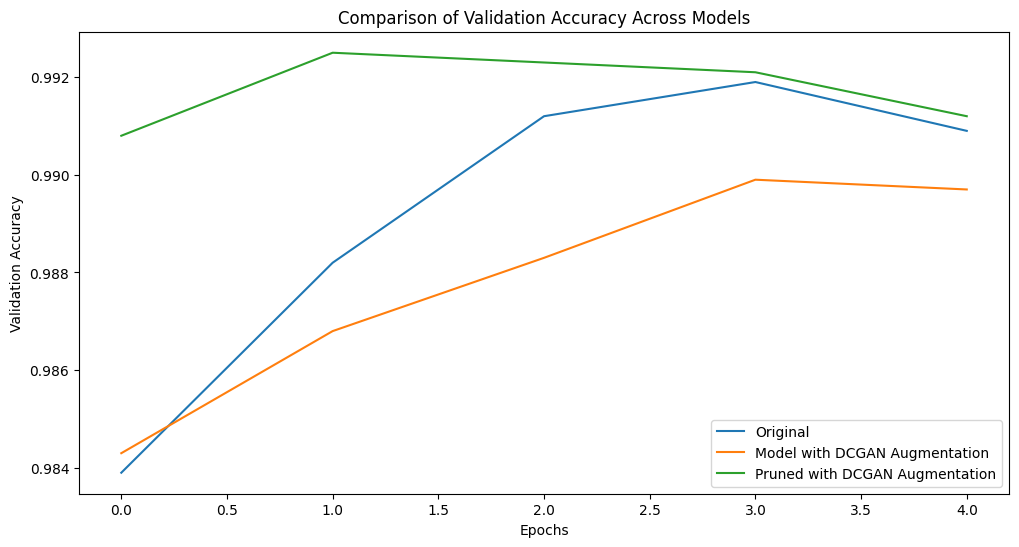

In [23]:
plt.figure(figsize=(12, 6))

# Plot validation accuracy for each model
plt.plot(history_orig.history['val_accuracy'], label='Original')
plt.plot(history_aug.history['val_accuracy'], label='Model with DCGAN Augmentation')
plt.plot(history_pruned_aug.history['val_accuracy'], label='Pruned with DCGAN Augmentation')

# Labeling the axes and adding a title
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Comparison of Validation Accuracy Across Models')

# Adding a legend to differentiate the lines
plt.legend()

# Display the plot
plt.show()